In [21]:

# coding: utf-8

# #### https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

# In[31]:


# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler #
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, RANSACRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.3f' % x)
get_ipython().run_line_magic('matplotlib', 'inline')


# In[32]:


import sklearn.neighbors as skn
import sklearn.metrics as skm

import libpysal as lp
import geopandas
import shapely.geometry as shp

from libpysal.weights.util import fill_diagonal
import statsmodels.api as sm

def run_regression(linear_model_type, outlier_way, numFeatures, spatial_numfeatures):
   
    linear_model_type = linear_model_type # LinearRegression = 0, RANSACRegressor = 1, Spatial Regression = 2

    spatial_numfeatures = spatial_numfeatures

    outlier_way = outlier_way # 0: without dummy, 1: dummy variable for all, 2: dummy variables for each feature

    numFeatures = numFeatures # 0: considering all features, 1: considering onty top 5 features from correlation matrix, 2: considering onty top 10 features  from correlation matrix

    
    df = pd.read_excel("df_Merge_ASDnVehiclenCompany_noMissingCol.xlsx")
    # df.drop(columns='Unnamed: 0', axis=1, inplace=True)


    # In[35]:


    # Check for duplicates
    idsUnique = len(set(df.Landkreis))
    idsTotal = df.shape[0]
    idsDupli = idsTotal - idsUnique
    print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")


    # In[36]:


    # Find most important features relative to target
    print("Find most important features relative to target")
    corr = df.corr()
    corr.sort_values(["Number of machinery"], ascending = False, inplace = True)
    corr["Number of machinery"].head(20)


    # ### Handle remaining missing values for numerical features by using median as replacement

    # In[37]:


    print("NAs for numerical features in train : " + str(df.isnull().values.sum()))
    # df_num = df_num.fillna(0)
    # print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))


    # In[38]:


    if linear_model_type == 2:
        landkreise = geopandas.read_file("zip://./geodata/landkreise-in-germany.zip")

        landkreise_feature = landkreise.columns
        useless_feature = landkreise_feature.drop(['geometry', 'id_2'])
        useless_feature

        landkreise.drop(useless_feature, axis=1, inplace=True)
        landkreise.rename(columns={'id_2':'ID'}, inplace=True)

        df_temp = pd.read_excel('preprocessing_landkreisGeometry.xlsx')
        landkreisenGeometry = pd.merge(landkreise, df_temp, on="ID", how='inner')
        landkreisenGeometry.drop(labels='LKR-ID', axis=1, inplace=True)
        landkreisenGeometry

        df = pd.merge(landkreisenGeometry, df, on="Landkreis", how='left')
        df = df.drop(['ID'], axis=1)

    print("NAs for numerical features in train : " + str(df.isnull().values.sum()))
    df = df.fillna(0)
    print("Remaining NAs for numerical features in train : " + str(df.isnull().values.sum()))


    # ### Differentiate numerical features (minus the target) and categorical features

    # In[39]:


    categorical_features = df.select_dtypes(include = ["object"]).columns
    # categorical_features = categorical_features.drop(['geometry'])
    numerical_features = df.select_dtypes(exclude = ["object"]).columns
    print("Numerical features : " + str(len(numerical_features)))
    print("Categorical features : " + str(len(categorical_features)))
    df_num = df[numerical_features]
    df_cat = df[categorical_features]
    df_num.drop(columns=['LKR-ID'], inplace=True) # LKR-ID is just a classification number


    # In[40]:


    numerical_features


    # In[41]:
    spatial_features_label = ''

    if linear_model_type == 2:   

        kW = lp.weights.Kernel.from_dataframe(df, fixed=False, function='gaussian', k=100)
        kW.transform = 'r'
        kW = fill_diagonal(kW, 0)

        # onlyX = sm.OLS(y,sm.add_constant(Xtable)).fit()
        # onlyX.summary()

        if spatial_numfeatures == 0:
            spatial_features_label = 'Spatial lag for all features'       
            spatial_features = df_num.columns 
            spatial_features = spatial_features.drop(["Number of machinery"])
        elif spatial_numfeatures == 1:
            spatial_features_label = 'Spatial lag for Sum of Number of Tractors, Lw. Betriebe gesamt'
            spatial_features = ['Sum of Number of Tractors', 'Lw. Betriebe gesamt']

        X = df[spatial_features]
        WX = lp.weights.lag_spatial(kW, X)

    #     Xtable = pd.DataFrame(df_num, columns=df_num.columns)
        WXtable = pd.DataFrame(WX, columns=['lag_{}'.format(name) for name in spatial_features])
        df_num = pd.concat((df_num,WXtable),axis=1)

    print(df_num.shape)
    # withWX = sm.OLS(y,sm.add_constant(XWXtable)).fit()
    # withWX.summary()


    # # Dealing with outliers
    # #### https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

    # In[42]:


    from scipy import stats

    ### Dealing with outliers by means of Z value

    ### Dealing with outliers by means of dummy variable
    Q1 = df_num.quantile(0.25)
    Q3 = df_num.quantile(0.75)
    IQR = Q3 - Q1

    df_dummy = df_num.copy()
    if outlier_way == 1:
        df_dummy['dummy variable for outliers'] = 0
        df_dummy.loc[df_dummy[((df_dummy < (Q1 - 1.5 * IQR)) | 
                              (df_dummy > (Q3 + 1.5 * IQR))).any(axis=1)].index, ['dummy variable for outliers']] = 1


    elif outlier_way == 2:
        for column in df_num.columns:
            df_dummy['DV for ' + column] = 0
            df_dummy.loc[df_dummy[((df_dummy[column] < (Q1[column] - 1.5 * IQR[column])) | 
                              (df_dummy[column] > (Q3[column] + 1.5 * IQR[column])))].index, ['DV for ' + column]] = 1

    features = df_num.columns
    df_dummy.drop(columns=features, inplace=True)
    ###
    print(df_num.shape)
    print(df_dummy.shape)


    # # log transformation

    # In[43]:


    #hstogram
    sns.distplot(df_num['Number of machinery']);


    # In[44]:


    # Log transform of the skewed numerical features to lessen impact of outliers
    # As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
    skewness = df_num.apply(lambda x: skew(x))
    skewness = skewness[abs(skewness) > 0.5]
    print(str(skewness.shape[0]) + " skewed numerical features to log transform")
    skewed_features = skewness.index
    df_num[skewed_features] = np.log1p(df_num[skewed_features])


    # In[45]:


    #hstogram
    sns.distplot(df_num['Number of machinery']);


    # # Standardize numerical features
    # ### Scale to [0;1] (give equal weight to all features, assuming a linear distribution of values and no significant outliers)
    # ### Shift mean to 0 (to center the data set; this will not affect the output at all for most algorithms.)

    # In[46]:


    # Standardize numerical features
    features = df_num.columns
    stdSc = StandardScaler()
    df_num = stdSc.fit_transform(df_num)
    df_num = pd.DataFrame.from_records(df_num)
    df_num.columns = features


    # # differentiate dependent and indenpendent data

    # In[47]:


    if outlier_way > 0:
        df_num = pd.concat([df_num, df_dummy], axis=1)
        print(df_num.shape)
    y = df_num["Number of machinery"]
    y_features = df_num.columns
    y_features = y_features.drop("Number of machinery")
    df_num = df_num[y_features]


    # In[48]:


    if numFeatures == 1:
        nonfive_features = df_num.columns
        five_features = ['Betriebe Zuchtsauen', 'Ackerbaubetriebe', 'Betriebe 50-100 ha', 'LW-Fläche 50-100 ha', 'Betriebe Schweine']
        nonfive_features = nonfive_features.drop(five_features)
        df_num.drop(columns=nonfive_features, inplace=True)
    if numFeatures == 2:
        nonten_features = df_num.columns
        ten_features = ['Betriebe Zuchtsauen', 'Ackerbaubetriebe', 'Betriebe 50-100 ha', 'LW-Fläche 50-100 ha', 'Betriebe Schweine',
                    'Sum of Number of Tractors', 'Viehbestand GV', 'Anzahl Zuchtsauen', 'Lw. Betriebe gesamt', 'Betriebe Viehhaltung']
        nonten_features = nonten_features.drop(ten_features)
        df_num.drop(columns=nonten_features, inplace=True)


    # # Modeling

    # In[49]:


    # Join categorical and numerical features
    # train = pd.concat([df_num, df_cat], axis = 1)
    train = df_num
    print("New number of features : " + str(train.shape[1]))

    # Partition the dataset in train + validation sets
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.25, random_state = 0)
    print("X_train : " + str(X_train.shape))
    print("X_test : " + str(X_test.shape))
    print("y_train : " + str(y_train.shape))
    print("y_test : " + str(y_test.shape))

    # Define error measure for official scoring : RMSE
    scorer = make_scorer(mean_squared_error, greater_is_better = False)

    def rmse_cv_train(model):
        rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10)) # k-fold, set k as 10
        return(rmse)

    def rmse_cv_test(model):
        rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
        return(rmse)

    # # 1* Linear Regression without regularization

    # In[50]:


    # Look at predictions on training and validation set
    # printing values

    # Linear Regression
    if linear_model_type == 0 or linear_model_type == 2:
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        lr_coef = list(zip(lr.coef_, df_num.columns))
        lr_coef.sort(reverse=True)
        intercept_ = lr.intercept_

    if linear_model_type == 1:
        lr = RANSACRegressor()
        lr.fit(X_train, y_train)
        lr_coef = list(zip(lr.estimator_.coef_, df_num.columns))
        lr_coef.sort(reverse=True)
        intercept_ = lr.estimator_.intercept_

    if linear_model_type == 0:
        linear_model_type_label = 'LinearRegression'
        print(linear_model_type_label)
    elif linear_model_type == 1:
        linear_model_type_label = 'RANSACRegression'
        print(linear_model_type_label)
    elif linear_model_type == 2:
        linear_model_type_label = 'SpatialRegression'
        print(linear_model_type_label)

    if outlier_way == 0:
        outlier_way_label = 'without dummy'
        print(outlier_way_label)
    elif outlier_way == 1:
        outlier_way_label = 'Dummy for all features'
        print(outlier_way_label)
    elif outlier_way == 2:
        outlier_way_label = 'Dummy for each feature'
        print(outlier_way_label)
        
    if numFeatures == 0:
        numFeatures_label = 'Considering all features'   
        print(numFeatures_label)
    elif numFeatures == 1:
        numFeatures_label = 'Considering only Top 5 features'
        print(numFeatures_label)
    elif numFeatures == 2:
        numFeatures_label = 'Considering only Top 10 features'
        print(numFeatures_label)

    print("RMSE on Training set :", rmse_cv_train(lr).mean())
    print("RMSE on Test set :", rmse_cv_test(lr).mean())
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    df_lr_coef = pd.DataFrame.from_records(lr_coef, columns=['coef', 'features'])
    print('Intercept:', intercept_)
    print('R2 score of train: ', r2_train)
    print('R2 score of test: ', r2_test)

    # Plot residuals
    plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title("Linear regression")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc = "upper left")
    plt.hlines(y = 0, xmin = 0, xmax = 8, color = "red")
#     plt.show()

    # Plot predictions
    plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title("Linear regression")
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.plot([0, 8], [0, 8], c = "red")
#     plt.show()

    df_lr_coef.head(20)
    top5_features = []
    for feature in df_lr_coef.nlargest(3, 'coef').features:
        top5_features.append(feature)
        
    return linear_model_type_label, outlier_way_label, numFeatures_label, spatial_features_label, rmse_cv_train(lr).mean(), rmse_cv_test(lr).mean(), intercept_, r2_train, r2_test
          

    

# Decision variables
linear_model_type = linear_model_type # LinearRegression = 0, RANSACRegressor = 1, Spatial Regression = 2

spatial_numfeatures = spatial_numfeatures

outlier_way = outlier_way # 0: without dummy, 1: dummy variable for all, 2: dummy variables for each feature

numFeatures = numFeatures # 0: considering all features, 1: considering onty top 5 features from correlation matrix, 
2: considering onty top 10 features  from correlation matrix

There are 0 duplicate IDs for 401 total entries
Find most important features relative to target
NAs for numerical features in train : 0
NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0
Numerical features : 57
Categorical features : 2
(401, 56)
(401, 56)
(401, 0)
55 skewed numerical features to log transform
New number of features : 55
X_train : (300, 55)
X_test : (101, 55)
y_train : (300,)
y_test : (101,)
LinearRegression
without dummy
Considering all features
RMSE on Training set : 0.6467556682453274
RMSE on Test set : 1.1753970733211623
Intercept: 0.0017668529905425293
R2 score of train:  0.7373045494213768
R2 score of test:  0.49491856997980677
There are 0 duplicate IDs for 401 total entries
Find most important features relative to target
NAs for numerical features in train : 0
NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0
Numerical features : 57
Categorical features : 2
(401, 56)
(401, 56)
(401, 0)

There are 0 duplicate IDs for 401 total entries
Find most important features relative to target
NAs for numerical features in train : 0
NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0
Numerical features : 57
Categorical features : 2
(401, 56)
(401, 56)
(401, 56)
55 skewed numerical features to log transform
(401, 112)
New number of features : 111
X_train : (300, 111)
X_test : (101, 111)
y_train : (300,)
y_test : (101,)
LinearRegression
Dummy for each feature
Considering all features
RMSE on Training set : 558870851555.5836
RMSE on Test set : 6.479962244182788
Intercept: -8.383252518579659e-05
R2 score of train:  0.78527354517013
R2 score of test:  -4.883265322127009e+24
There are 0 duplicate IDs for 401 total entries
Find most important features relative to target
NAs for numerical features in train : 0
NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0
Numerical features : 57
Categorical features : 2
(401

New number of features : 10
X_train : (300, 10)
X_test : (101, 10)
y_train : (300,)
y_test : (101,)
SpatialRegression
without dummy
Considering only Top 10 features
RMSE on Training set : 0.6072036614667501
RMSE on Test set : 0.6755147686898691
Intercept: -0.01511698844227646
R2 score of train:  0.6565107463196275
R2 score of test:  0.585054642024528
There are 0 duplicate IDs for 401 total entries
Find most important features relative to target
NAs for numerical features in train : 0
NAs for numerical features in train : 522
Remaining NAs for numerical features in train : 0
Numerical features : 57
Categorical features : 3
(401, 111)
(401, 111)
(401, 1)
92 skewed numerical features to log transform
(401, 112)
New number of features : 111
X_train : (300, 111)
X_test : (101, 111)
y_train : (300,)
y_test : (101,)
SpatialRegression
Dummy for all features
Considering all features
RMSE on Training set : 0.77244502641647
RMSE on Test set : 1.889114053194603
Intercept: -0.0748835964214924
R2 sc

There are 0 duplicate IDs for 401 total entries
Find most important features relative to target
NAs for numerical features in train : 0
NAs for numerical features in train : 522
Remaining NAs for numerical features in train : 0
Numerical features : 57
Categorical features : 3
(401, 58)
(401, 58)
(401, 58)
55 skewed numerical features to log transform
(401, 116)
New number of features : 10
X_train : (300, 10)
X_test : (101, 10)
y_train : (300,)
y_test : (101,)
SpatialRegression
Dummy for each feature
Considering only Top 10 features
RMSE on Training set : 0.6072036614667501
RMSE on Test set : 0.6755147686898691
Intercept: -0.01511698844227646
R2 score of train:  0.6565107463196275
R2 score of test:  0.585054642024528
There are 0 duplicate IDs for 401 total entries
Find most important features relative to target
NAs for numerical features in train : 0
NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0
Numerical features : 57
Categorical features : 2

RANSACRegression
Dummy for all features
Considering only Top 10 features
RMSE on Training set : 0.733327615461228
RMSE on Test set : 1.4018756648139201
Intercept: 0.12623708541414258
R2 score of train:  0.5014731317432403
R2 score of test:  0.4228425342173434
There are 0 duplicate IDs for 401 total entries
Find most important features relative to target
NAs for numerical features in train : 0
NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0
Numerical features : 57
Categorical features : 2
(401, 56)
(401, 56)
(401, 1)
55 skewed numerical features to log transform
(401, 57)
New number of features : 10
X_train : (300, 10)
X_test : (101, 10)
y_train : (300,)
y_test : (101,)
RANSACRegression
Dummy for all features
Considering only Top 10 features
RMSE on Training set : 1.6246866337289263
RMSE on Test set : 0.9728988567506901
Intercept: -0.023069212179338855
R2 score of train:  0.5669301797628217
R2 score of test:  0.35297062005896185


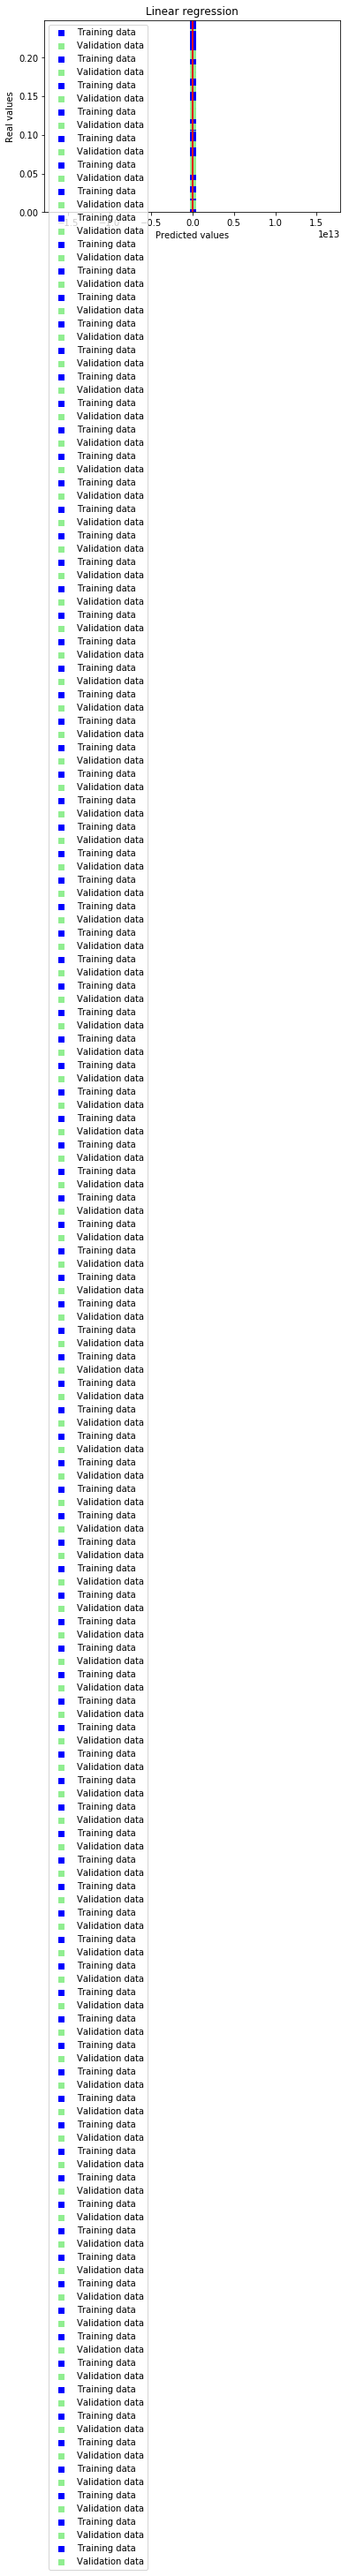

In [22]:
Model = []
rmse_train = []
rmse_test = []
R2_train = []
R2_test = []
intercept = []

spatial_numfeatures = 0
outlier_way = 0
numFeatures = 0
spatial_features = 0
for linear_model_type in range(0,3,2):
    for outlier_way in range(3): # robust linear regression can not do dummy for each feature
        for numFeatures in range(3):
            for spatial_features in range(2):
                linear_model_type_label, outlier_way_label, numFeatures_label, spatial_features_label, rmse_cv_train, rmse_cv_test, intercept_, r2_train, r2_test = \
                run_regression(linear_model_type, outlier_way, numFeatures, spatial_features)
                

                Model.append(linear_model_type_label + '/' + outlier_way_label + '/' + numFeatures_label + '/' + spatial_features_label)
                rmse_train.append(rmse_cv_train)
                rmse_test.append(rmse_cv_test)
                R2_train.append(r2_train)
                R2_test.append(r2_test)
                intercept.append(intercept_)
                
for linear_model_type in range(1,2):
    for outlier_way in range(2): # robust linear regression can not do dummy for each feature
        for numFeatures in range(3):
            for spatial_features in range(2):
                linear_model_type_label, outlier_way_label, numFeatures_label, spatial_features_label, rmse_cv_train, rmse_cv_test, intercept_, r2_train, r2_test = \
                run_regression(linear_model_type, outlier_way, numFeatures, spatial_features)

                Model.append(linear_model_type_label + '/' + outlier_way_label + '/' + numFeatures_label + '/' + spatial_features_label)
                rmse_train.append(rmse_cv_train)
                rmse_test.append(rmse_cv_test)
                R2_train.append(r2_train)
                R2_test.append(r2_test)
                intercept.append(intercept_)
    
result = {'Model': Model,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'R2_train': R2_train,
        'R2_test': R2_test,
        'intercept': intercept
        }
df_test = pd.DataFrame(result, columns= ['Model', 'rmse_train', 'rmse_test', 'R2_train', 'R2_test', 'intercept'])

In [23]:
df_test

,Model,rmse_train,rmse_test,R2_train,R2_test,intercept
0,LinearRegression/without dummy/Considering all...,0.647,1.175,0.737,0.495,0.002
1,LinearRegression/without dummy/Considering all...,0.647,1.175,0.737,0.495,0.002
2,LinearRegression/without dummy/Considering onl...,0.605,0.661,0.640,0.582,0.016
3,LinearRegression/without dummy/Considering onl...,0.605,0.661,0.640,0.582,0.016
4,LinearRegression/without dummy/Considering onl...,0.576,0.705,0.681,0.577,0.001
5,LinearRegression/without dummy/Considering onl...,0.576,0.705,0.681,0.577,0.001
6,LinearRegression/Dummy for all features/Consid...,0.642,1.202,0.744,0.480,-0.173
7,LinearRegression/Dummy for all features/Consid...,0.642,1.202,0.744,0.480,-0.173
8,LinearRegression/Dummy for all features/Consid...,0.605,0.661,0.640,0.582,0.016
9,LinearRegression/Dummy for all features/Consid...,0.605,0.661,0.640,0.582,0.016


In [24]:
df_test.to_excel('Model_result.xlsx')